### 1. Network Analysis

In [1]:
# Import libraries 
import cpnet # cpnet==0.0.20
import community 
import community.community_louvain
import numpy as np # version: 1.23.2
import pandas as pd # version: 1.5.0
import networkx as nx # version: 2.8.7
import matplotlib.pyplot as plt # version: 3.6.0

#### Data loading and cleaning

In [9]:
# load the processed dataset
df = pd.read_csv('New_Data/AAVE_transaction_data_after_preprocessing_New.csv')
# df = pd.read_csv('Existing_Data/AAVE_transaction_data_after_preprocessing.csv')

In [10]:
# clean the time stamp columns
df_time_partition= df.groupby(['timestamp'])['to_address'].agg(['nunique']).reset_index()
df_time_partition = df_time_partition.drop(['nunique'], axis=1)

#### Number of transaction over the selected period

<AxesSubplot:title={'center':'Monthly Transaction count'}, xlabel='Month_Year'>

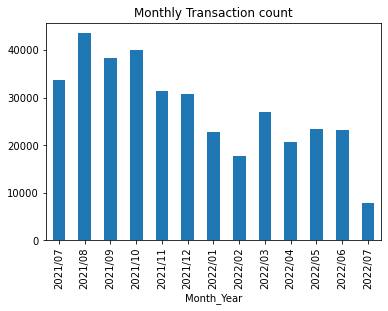

In [11]:
# create a new month_year column
df['Month_Year'] = df["timestamp"].apply(lambda x: x[:len(x)-3])
# create the count dataframe
df_count = df.groupby(["Month_Year"])["Month_Year"].count()
# plot the transaction bar chart
df_count.plot(kind="bar", title="Monthly Transaction count")

#### a. Number of daily edges and nodes

In [12]:
num_nodes = []
num_edges = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Number of nodes, number of edges
    nodes = G.number_of_nodes()
    edges = G.number_of_edges()
    num_nodes.append(nodes)
    num_edges.append(edges)

In [13]:
Network_Features={"num_nodes" : num_nodes,"num_edges" : num_edges}
Network_Features=pd.DataFrame(Network_Features)
Network_Features['time'] =  df_time_partition['timestamp']

#### b. Degree

In [6]:
Degreemean = []
Degreestd = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Degree_centrality, mean_value
    degrees = G.degree()
    degree = list(dict(G.degree()).values())
    df_deg = {"Degree" : degree}
    df_deg = pd.DataFrame(df_deg)
    DC_mean = df_deg['Degree'].mean()
    DC_std = df_deg['Degree'].std()
    Degreemean.append(DC_mean)
    Degreestd.append(DC_std)

In [7]:
Network_Features['Degree mean']  = Degreemean
Network_Features['Degree std']  = Degreestd

#### c. Top 10 addresses degree ratio

In [8]:
top10Degreemean = []
top10Degreestd = []

for i in range(0,len(df_time_partition)):

    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    sender_mdegree= df_1.groupby(['from_address'])['to_address'].count().reset_index()
    receiver_mdegree = df_1.groupby(['to_address'])['from_address'].count().reset_index()
    sender_mdegree = sender_mdegree.rename(columns={'to_address':'degree'})
    sender_mdegree = sender_mdegree.rename(columns={'from_address':'address'})
    receiver_mdegree = receiver_mdegree.rename(columns = {'from_address':'degree'})
    receiver_mdegree = receiver_mdegree.rename(columns = {'to_address':'address'})

    merge = pd.merge(sender_mdegree,receiver_mdegree,on="address",how = "outer")
    merge = merge.fillna(int(0))
    merge['degree'] = merge['degree_x']+merge['degree_y']

    merge.sort_values(by=['degree'], ascending=False, inplace=True)
    merge = merge.reset_index()
    top5degree = merge['address'][0:10].tolist()

    sen_top =  df_1[df_1['from_address'].isin(top5degree)]
    rec_top= df_1[df_1['to_address'].isin(top5degree)]

    topaddress = pd.concat([sen_top,rec_top]).drop_duplicates()

    G = nx.from_pandas_edgelist(topaddress, 'from_address', 'to_address', 'value', nx.Graph())
    # Calculation of absolute degree
    degree = []
    for j in range (0,10):
        degrees = G.degree(top5degree[j])
        degree.append(degrees)
    df_deg = {"Degree" : degree}
    df_deg = pd.DataFrame(df_deg)
    deg_mean = df_deg['Degree'].mean()
    deg_std = df_deg['Degree'].std()
    top10Degreemean.append(deg_mean)
    top10Degreestd.append(deg_std)

In [9]:
Network_Features['Top10Degree mean']  = top10Degreemean
Network_Features['Top10Degree std']  = top10Degreestd
Network_Features['Top10 Degree mean ratio']  = Network_Features['Top10Degree mean']/Network_Features['Degree mean']

d. Degree centrality

In [10]:
DCmean = []
DCstd = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Degree_centrality, mean_value
    deg_cen = nx.degree_centrality(G)
    df_deg = pd.DataFrame.from_dict(deg_cen, orient='index', columns=['Degree_Centrality'])
    DC_mean = df_deg['Degree_Centrality'].mean()
    DC_std = df_deg['Degree_Centrality'].std()
    DCmean.append(DC_mean)
    DCstd.append(DC_std)

#### e. Clustering coefficient

In [11]:
clustermean = []
clusterstd = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # Unweighted-Directed Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Clustering_Coefficient, mean_value, std
    clustering = nx.clustering(G)
    df_cluster = pd.DataFrame.from_dict(clustering, orient='index', columns=['Clustering_Coefficient'])
    cluster_mean = df_cluster['Clustering_Coefficient'].mean()
    cluster_std = df_cluster['Clustering_Coefficient'].std()
    clustermean.append(cluster_mean)
    clusterstd.append(cluster_std)

#### f. Modularity

In [12]:
mod_list = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # unweighted-undirected Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of modularity
    # part = community.best_partition(G)
    # mod = community.modularity(part,G)
    part = community.community_louvain.best_partition(G)
    mod = community.community_louvain.modularity(part,G)
    mod_list.append(mod)

#### g. Transitivity

In [13]:
tran_list = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # Unweighted-undirected Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of transitivity, 
    tran = nx.transitivity(G)
    tran_list.append(tran)

#### h. Eigenvector Centrality

In [14]:
eigmean = []
eigstd = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Closeness_centrality, mean_value
    eig_cen = nx.eigenvector_centrality(G, max_iter=20000)
    df_eig = pd.DataFrame.from_dict(eig_cen, orient='index', columns=['eigenvector_centrality'])
    eig_mean = df_eig['eigenvector_centrality'].mean()
    eig_std = df_eig['eigenvector_centrality'].std()
    eigmean.append(eig_mean)
    eigstd.append(eig_std)

#### i. Closeness Centrality

In [15]:
CCmean = []
CCstd = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Closeness_centrality, mean_value
    close_cen = nx.closeness_centrality(G)
    df_close = pd.DataFrame.from_dict(close_cen, orient='index', columns=['Closeness_Centrality'])
    CC_mean = df_close['Closeness_Centrality'].mean()
    CC_std = df_close['Closeness_Centrality'].std()
    CCmean.append(CC_mean)
    CCstd.append(CC_std)

#### j. Number of components

In [16]:
components_cnt = []
for i in range(0,len(df_time_partition)):
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    com_cnt = nx.number_connected_components(G)
    components_cnt.append(com_cnt)

#### k. Size of gaint component / num of nodes

In [17]:
giant_com_ratio = []
for i in range(0,len(df_time_partition)):
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
# G = nx.Graph()
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
#com_cnt = nx.number_connected_components(G)
#components_cnt.append(com_cnt)
    nodes = G0.number_of_nodes()
    nodes_whole = G.number_of_nodes()
    ratio = nodes/nodes_whole
    giant_com_ratio.append(ratio)

In [18]:
Network_Features['DCmean']=DCmean
Network_Features['DCstd']=DCstd
Network_Features['clustermean']=clustermean
Network_Features['clusterstd']=clusterstd
Network_Features['modularity']=mod_list
Network_Features['transitivity']=tran_list
Network_Features['eig_mean']=eigmean
Network_Features['eig_std']=eigstd
Network_Features['closenessmean']=CCmean
Network_Features['closenessstd']=CCstd
Network_Features['Components_cnt']=components_cnt
Network_Features['giant_com_ratio']=giant_com_ratio

Network_Features['token'] =  'AAVE'
Network_Features.head()

,num_nodes,num_edges,time,Degree mean,Degree std,Top10Degree mean,Top10Degree std,Top10 Degree mean ratio,DCmean,DCstd,...,clusterstd,modularity,transitivity,eig_mean,eig_std,closenessmean,closenessstd,Components_cnt,giant_com_ratio,token
0,702,807,1/01/2022,2.299145,6.246617,38.1,36.336238,16.571375,0.003280,0.008911,...,0.067652,0.757362,0.001019,0.014117,0.035028,0.140053,0.071031,57,0.813390,AAVE
1,522,612,1/02/2022,2.344828,5.278779,30.9,23.946468,13.177941,0.004501,0.010132,...,0.078656,0.761401,0.001114,0.016946,0.040394,0.150175,0.064853,31,0.865900,AAVE
2,628,740,1/03/2022,2.356688,5.762456,36.2,28.700755,15.360541,0.003759,0.009191,...,0.083775,0.757652,0.001052,0.015554,0.036778,0.136294,0.067145,48,0.829618,AAVE
3,1061,1506,1/04/2022,2.838831,6.846803,61.9,26.366856,21.804748,0.002678,0.006459,...,0.116261,0.713203,0.006518,0.014171,0.027247,0.155349,0.064463,57,0.874647,AAVE
4,403,444,1/05/2022,2.203474,3.394213,19.9,8.659613,9.031194,0.005481,0.008443,...,0.018996,0.774826,0.005263,0.021098,0.045181,0.133133,0.062907,31,0.833747,AAVE


#### Output network features dataset

In [19]:
Network_Features.to_csv('Output_Data/AAVE_Network_Features_New.csv')

### 2. Core-periphery Analysis

#### a. Basic structure significance test

##### Save the significant testing results for each day during the 1-year period

In [ ]:
# loop to get the p-value for every day of transactions
p_value_list = []

for i in range(0, 365):
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())

    alg = cpnet.BE() # BE algorithm
    alg.detect(G)
    c = alg.get_pair_id()
    x = alg.get_coreness()  # Get the coreness of nodes

    sig_c, sig_x, significant, p_values = cpnet.qstest(
        c, x, G, alg, significance_level=0.05, num_of_rand_net=100, num_of_thread=16)

    p_value_list.append(p_values)

In [ ]:
# create a dataframe to store cpnet testing results
df_cp_test = pd.DataFrame(df['timestamp'].unique(), columns = ["date"])
df_cp_test["p_value"] = p_value_list

# save the cp test results to csv
# df_cp_test.to_csv("Existing_Data/cp_test_results.csv", index = False) # outputs on existing dataset 
df_cp_test.to_csv("Output_Data/cp_test_results_new.csv", index = False) # outputs on new dataset

#### b. Continuous structure significance test

In [25]:
df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][29]]
G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
# Calculation of mean&std of coreness (continuous structure)
alg = cpnet.MINRES()
alg.detect(G)
c = alg.get_pair_id()
x = alg.get_coreness() 

sig_c, sig_x, significant, p_values = cpnet.qstest(
    c, x, G, alg, significance_level=0.05, num_of_rand_net=100, num_of_thread=16)

d:\ProgramData\Anaconda3\lib\site-packages\cpnet\qstest.py:94: UserWarning: 'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.
  warnings.warn("'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.")
100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


In [26]:
# check the results
print(significant)
print(p_values)

[False]
[0.5389535090230269]


#### c. Core-periphery Network Graph (using basic structure significance test results)

##### Core-periphery Network plot for significant day

In [27]:
df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][29]] # significant day (p_value < 0.05)
G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())

alg = cpnet.BE()
alg.detect(G)
c = alg.get_pair_id()
x = alg.get_coreness()  # Get the coreness of nodes

sig_c, sig_x, significant, p_values = cpnet.qstest(
    c, x, G, alg, significance_level=0.05, num_of_rand_net=100, num_of_thread=16)

100%|██████████| 100/100 [12:07<00:00,  7.27s/it]


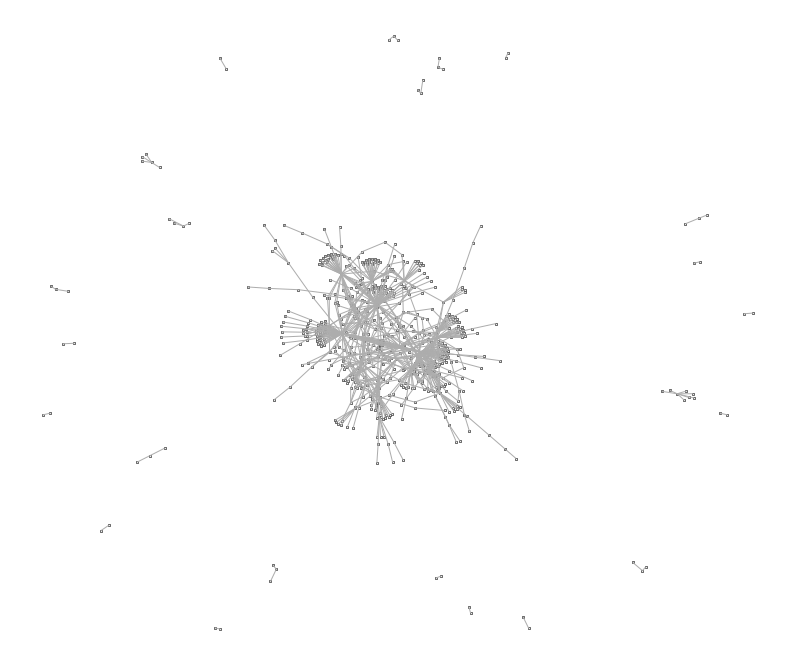

In [28]:
pos = nx.spiral_layout(G,scale = 3)
fig = plt.figure(figsize=(14, 12))
ax = plt.gca()
draw_nodes_kwd = {"node_size": 80, "linewidths": 0.8}
ax, pos = cpnet.draw(G, sig_c, sig_x, ax,draw_nodes_kwd=draw_nodes_kwd) # cpnet==0.0.21

# ax, pos = cpnet.draw(G, sig_c, sig_x, ax,draw_nodes_kwd=draw_nodes_kwd,
#                      layout_kwd = {"verbose":True, "iterations":500}) # cpnet==0.0.20

##### Core-periphery Network plot for insignificant day

In [32]:
df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][247]] # insignificant day (p_value > 0.05)
G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())

alg = cpnet.BE()
alg.detect(G)
c = alg.get_pair_id()
x = alg.get_coreness()  # Get the coreness of nodes

sig_c, sig_x, significant, p_values = cpnet.qstest(
    c, x, G, alg, significance_level=0.05, num_of_rand_net=100, num_of_thread=16)

100%|██████████| 100/100 [49:30<00:00, 29.71s/it]


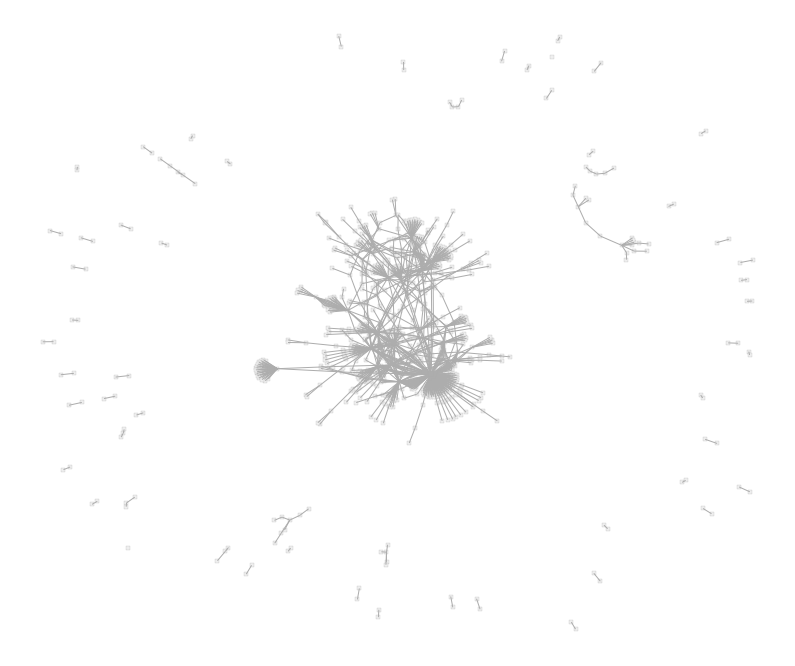

In [42]:
pos = nx.spiral_layout(G,scale = 6) # default scale 3
fig = plt.figure(figsize=(14, 12))
ax = plt.gca()
# draw_nodes_kwd = {"node_size": 80, "linewidths": 0.8}
draw_nodes_kwd = {"node_size": 100, "linewidths": 0.1}
ax, pos = cpnet.draw(G, sig_c, sig_x, ax,draw_nodes_kwd=draw_nodes_kwd) # cpnet==0.0.21

# ax, pos = cpnet.draw(G, sig_c, sig_x, ax,draw_nodes_kwd=draw_nodes_kwd,
#                      layout_kwd = {"verbose":True, "iterations":500}) # cpnet==0.0.20

#### d. Output core addresses and corresponding date counts

In [ ]:
core_address = []
a = 0
for i in range(0,len(df_time_partition)):
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    alg = cpnet.BE()
    alg.detect(G)
    c = alg.get_pair_id()
    x = alg.get_coreness()

    coredf = pd.DataFrame.from_dict(x, orient='index',columns=['coreness'])
    core = coredf[coredf['coreness']==1].index.tolist()
    core_address.extend(core)
    a+=1
    print(a)

In [26]:
cores = pd.DataFrame(core_address)
core_cnt = cores[0].value_counts(ascending=False).reset_index()
core_cnt.head()

,index,0
0,0xddfabcdc4d8ffc6d5beaf154f18b778f892a0740,356
1,0x28c6c06298d514db089934071355e5743bf21d60,258
2,0x4da27a545c0c5b758a6ba100e3a049001de870f5,221
3,0x5ab53ee1d50eef2c1dd3d5402789cd27bb52c1bb,201
4,0xd75ea151a61d06868e31f8988d28dfe5e9df57b4,195


In [27]:
core_cnt.to_csv('Output_Data/core_date_cnt_new.csv')

#### e. Number of core members each day

In [20]:
core_cnt = []
for i in range(0,len(df_time_partition)):
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    alg = cpnet.BE()
    alg.detect(G)
    c = alg.get_pair_id()
    x = alg.get_coreness()

    coredf = pd.DataFrame.from_dict(x, orient='index',columns=['coreness'])
    core = coredf[coredf['coreness']==1].index.tolist()
    cnt = len(core)
    core_cnt.append(cnt)

#### f. Average number of neighbors of cores

In [21]:
from numpy import *
avg_core_neighbor = []

for i in range(0,len(df_time_partition)):
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    alg = cpnet.BE()
    alg.detect(G)
    c = alg.get_pair_id()
    x = alg.get_coreness()

    coredf = pd.DataFrame.from_dict(x, orient='index',columns=['coreness'])
    core = coredf[coredf['coreness']==1].index.tolist()

    neighbor_cnt = []
    for i in range (0,len(core)):
        neighbor = G.degree(core[i])
        neighbor_cnt.append(neighbor)
    
    neighbor_cnt_mean = mean(neighbor_cnt)
    avg_core_neighbor.append(neighbor_cnt_mean)

#### g. Update Network Features dataset

In [22]:
Network_Features = pd.read_csv('Output_Data/AAVE_Network_Features_New.csv')
Network_Features['core_cnt']=core_cnt
Network_Features['core_ratio']=Network_Features['core_cnt']/Network_Features['num_nodes']
Network_Features['avg_core_neighbor']=avg_core_neighbor

In [23]:
# Deal with the outlier
# average of past 5 days
Network_Features['core_cnt'][230]=2
Network_Features['core_ratio'][230] = 2/Network_Features['num_nodes'][230]
Network_Features['avg_core_neighbor'][230] = 217.8

<ipython-input-23-7c9150d12c27>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Network_Features['core_cnt'][230]=2
<ipython-input-23-7c9150d12c27>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Network_Features['core_ratio'][230] = 2/Network_Features['num_nodes'][230]
<ipython-input-23-7c9150d12c27>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Network_Features['avg_core_neighbor'][230] = 217.8


##### updated the Network Feature csv file

In [24]:
Network_Features.to_csv('Output_Data/AAVE_Network_Features_Updated.csv')